In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold, cross_val_score
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

df = pd.read_csv('final_data.csv')
pca = PCA()

# Define cross-validation folds
cv = KFold(n_splits=10, shuffle=True, random_state=42)

C:\Users\Navdeep Singh Saini\miniconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


[28.02 42.65 52.99 59.85 65.56 70.19 74.05 77.43 80.63 83.47 85.49 87.36
 89.09 90.41 91.57 92.68 93.57 94.28 94.91 95.48 95.96 96.39 96.79 97.15
 97.46 97.72 97.96 98.19 98.37 98.53 98.67 98.81 98.94 99.05 99.15 99.24
 99.32 99.39 99.45 99.51 99.56 99.61 99.65 99.69 99.73 99.76 99.79 99.82
 99.84 99.86 99.88 99.9  99.91 99.92 99.93 99.94 99.95 99.96 99.97 99.98
 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98
 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98
 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98
 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98
 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98
 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98
 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98
 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98
 99.98 99.98 99.98 99.98 99.98]
MSE training set 91

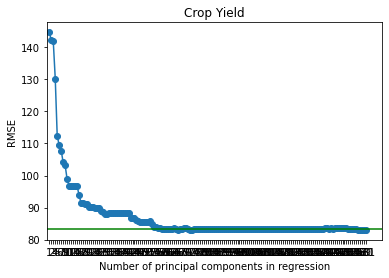

In [41]:
df_new1 = df[df['ECODISTRICT_ID'] == 748]

df_new1.drop(['TWP_ID','ECODISTRICT_ID','YEAR'], axis=1, inplace= True)

Y = df_new1['YieldKgAcre']
df_new1.drop('YieldKgAcre', axis=1, inplace= True)
X = df_new1
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

# Run standardization on X variables
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)


# Linear Regression
lin_reg = LinearRegression().fit(X_train_scaled, y_train)
lr_score_train = -1 * cross_val_score(lin_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lr_score_test = mean_squared_error(y_test, lin_reg.predict(X_test_scaled), squared=False)

# Generate all the principal components
## pca = PCA() # Default n_components = min(n_samples, n_features)
X_train_pc = pca.fit_transform(X_train_scaled)

# View first 5 rows of all principal components
pd.DataFrame(pca.components_.T).loc[:4,:]

print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

# Initialize linear regression instance
lin_reg = LinearRegression()

# Create empty list to store RMSE for each iteration
rmse_list = []

# Loop through different count of principal components for linear regression
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg, 
                                      X_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=cv, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)
    
# Visual analysis - plot RMSE vs count of principal components used
plt.plot(rmse_list, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('RMSE')
plt.title('Crop Yield')
plt.xlim(xmin=-1);
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle='-');

# determine optimal number of principal components
best_pc_num = 20

# Train model with first 9 principal components
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get cross-validation RMSE (train set)
pcr_score_train = -1 * cross_val_score(lin_reg_pc, 
                                       X_train_pc[:,:best_pc_num], 
                                       y_train, 
                                       cv=cv, 
                                       scoring='neg_root_mean_squared_error').mean()

# Train model on training set
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get first 20 principal components of test set
X_test_pc = pca.transform(X_test_scaled)[:,:best_pc_num]

# Predict on test data
preds = lin_reg_pc.predict(X_test_pc)
pcr_score_test = mean_squared_error(y_test, preds, squared=False)

print('MSE training set',round(pcr_score_train,2))
print('MSE test set',round(pcr_score_test,2))
print('R squared training set', round(lin_reg_pc.score(X_train_pc[:,:best_pc_num], y_train)*100, 2))
print('R squared test set', round(lin_reg_pc.score(X_test_pc[:,:best_pc_num], y_test)*100, 2))

# Calculate the absolute errors
errors = abs(preds - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

C:\Users\Navdeep Singh Saini\miniconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


[24.14 37.79 49.12 56.64 62.58 67.79 71.95 75.49 78.79 81.8  84.42 86.3
 87.83 89.11 90.23 91.29 92.18 92.97 93.67 94.23 94.73 95.19 95.63 96.
 96.35 96.67 96.96 97.22 97.47 97.68 97.88 98.05 98.2  98.34 98.47 98.59
 98.71 98.82 98.92 99.01 99.09 99.17 99.24 99.3  99.36 99.41 99.46 99.5
 99.54 99.57 99.6  99.63 99.66 99.69 99.71 99.73 99.75 99.77 99.79 99.81
 99.82 99.83 99.84 99.85 99.86 99.87 99.88 99.89 99.9  99.91 99.92 99.93
 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94
 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94
 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94
 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94
 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94
 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94
 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94
 99.94 99.94 99.94 99.94 99.94]
MSE training set 119.28

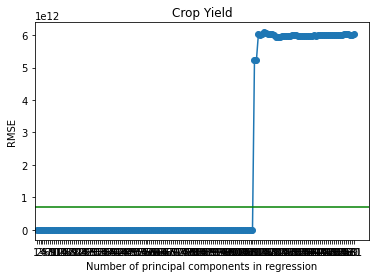

In [25]:
df_new2 = df[df['ECODISTRICT_ID'] == 826]

df_new2.drop(['TWP_ID','ECODISTRICT_ID','YEAR'], axis=1, inplace= True)

Y = df_new2['YieldKgAcre']
df_new2.drop('YieldKgAcre', axis=1, inplace= True)
X = df_new2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

# Run standardization on X variables
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

# Linear Regression
lin_reg = LinearRegression().fit(X_train_scaled, y_train)
lr_score_train = -1 * cross_val_score(lin_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lr_score_test = mean_squared_error(y_test, lin_reg.predict(X_test_scaled), squared=False)

# Generate all the principal components
## pca = PCA() # Default n_components = min(n_samples, n_features)
X_train_pc = pca.fit_transform(X_train_scaled)

# View first 5 rows of all principal components
pd.DataFrame(pca.components_.T).loc[:4,:]

print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

# Initialize linear regression instance
lin_reg = LinearRegression()

# Create empty list to store RMSE for each iteration
rmse_list = []

# Loop through different count of principal components for linear regression
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg, 
                                      X_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=cv, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)
    
# Visual analysis - plot RMSE vs count of principal components used
plt.plot(rmse_list, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('RMSE')
plt.title('Crop Yield')
plt.xlim(xmin=-1);
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle='-');

# determine optimal number of principal components
best_pc_num = 22

# Train model with first 9 principal components
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get cross-validation RMSE (train set)
pcr_score_train = -1 * cross_val_score(lin_reg_pc, 
                                       X_train_pc[:,:best_pc_num], 
                                       y_train, 
                                       cv=cv, 
                                       scoring='neg_root_mean_squared_error').mean()

# Train model on training set
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get first 22 principal components of test set
X_test_pc = pca.transform(X_test_scaled)[:,:best_pc_num]

# Predict on test data
preds = lin_reg_pc.predict(X_test_pc)
pcr_score_test = mean_squared_error(y_test, preds, squared=False)

print('MSE training set',round(pcr_score_train,2))
print('MSE test set',round(pcr_score_test,2))
print('R squared training set', round(lin_reg_pc.score(X_train_pc[:,:best_pc_num], y_train)*100, 2))
print('R squared test set', round(lin_reg_pc.score(X_test_pc[:,:best_pc_num], y_test)*100, 2))

# Calculate the absolute errors
errors = abs(preds - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

C:\Users\Navdeep Singh Saini\miniconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


[21.89 38.64 50.06 57.11 63.73 68.65 72.92 76.32 79.27 81.86 84.25 86.05
 87.46 88.82 90.06 91.07 91.89 92.63 93.29 93.91 94.5  94.99 95.46 95.9
 96.28 96.61 96.9  97.15 97.38 97.61 97.82 97.99 98.15 98.3  98.44 98.56
 98.67 98.77 98.86 98.94 99.02 99.09 99.16 99.22 99.28 99.33 99.38 99.43
 99.47 99.51 99.55 99.59 99.62 99.65 99.68 99.71 99.73 99.75 99.77 99.79
 99.81 99.83 99.84 99.85 99.86 99.87 99.88 99.89 99.9  99.91 99.92 99.93
 99.94 99.95 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96
 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96
 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96
 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96
 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96
 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96
 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96
 99.96 99.96 99.96 99.96 99.96]
MSE training set 100

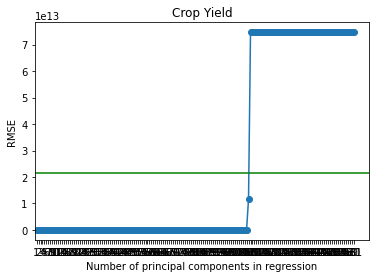

In [26]:
df_new3 = df[df['ECODISTRICT_ID'] == 752]

df_new3.drop(['TWP_ID','ECODISTRICT_ID','YEAR'], axis=1, inplace= True)

Y = df_new3['YieldKgAcre']
df_new3.drop('YieldKgAcre', axis=1, inplace= True)
X = df_new3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

# Run standardization on X variables
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

# Linear Regression
lin_reg = LinearRegression().fit(X_train_scaled, y_train)
lr_score_train = -1 * cross_val_score(lin_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lr_score_test = mean_squared_error(y_test, lin_reg.predict(X_test_scaled), squared=False)

X_train_pc = pca.fit_transform(X_train_scaled)

# View first 5 rows of all principal components
pd.DataFrame(pca.components_.T).loc[:4,:]

print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

# Initialize linear regression instance
lin_reg = LinearRegression()

# Create empty list to store RMSE for each iteration
rmse_list = []

# Loop through different count of principal components for linear regression
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg, 
                                      X_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=cv, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)
    
# Visual analysis - plot RMSE vs count of principal components used
plt.plot(rmse_list, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('RMSE')
plt.title('Crop Yield')
plt.xlim(xmin=-1);
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle='-');

# determine optimal number of principal components
best_pc_num = 23

# Train model with first 9 principal components
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get cross-validation RMSE (train set)
pcr_score_train = -1 * cross_val_score(lin_reg_pc, 
                                       X_train_pc[:,:best_pc_num], 
                                       y_train, 
                                       cv=cv, 
                                       scoring='neg_root_mean_squared_error').mean()

# Train model on training set
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get first 23 principal components of test set
X_test_pc = pca.transform(X_test_scaled)[:,:best_pc_num]

# Predict on test data
preds = lin_reg_pc.predict(X_test_pc)
pcr_score_test = mean_squared_error(y_test, preds, squared=False)

print('MSE training set',round(pcr_score_train,2))
print('MSE test set',round(pcr_score_test,2))
print('R squared training set', round(lin_reg_pc.score(X_train_pc[:,:best_pc_num], y_train)*100, 2))
print('R squared test set', round(lin_reg_pc.score(X_test_pc[:,:best_pc_num], y_test)*100, 2))

# Calculate the absolute errors
errors = abs(preds - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

C:\Users\Navdeep Singh Saini\miniconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


[29.2  42.86 53.12 61.27 67.27 71.92 75.82 78.87 81.77 84.49 86.66 88.48
 89.87 91.14 92.24 93.11 93.81 94.41 94.95 95.44 95.89 96.3  96.67 97.02
 97.32 97.58 97.82 98.03 98.22 98.38 98.53 98.67 98.81 98.93 99.04 99.14
 99.23 99.31 99.38 99.45 99.51 99.56 99.61 99.66 99.7  99.74 99.77 99.8
 99.83 99.85 99.87 99.89 99.91 99.93 99.94 99.95 99.96 99.97 99.98 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99]
MSE training set 92.

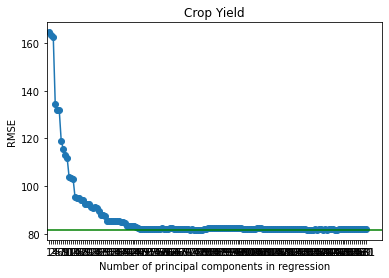

In [40]:
df_new4 = df[df['ECODISTRICT_ID'] == 745]

df_new4.drop(['TWP_ID','ECODISTRICT_ID','YEAR'], axis=1, inplace= True)

Y = df_new4['YieldKgAcre']
df_new4.drop('YieldKgAcre', axis=1, inplace= True)
X = df_new4
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

# Run standardization on X variables
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

# Linear Regression
lin_reg = LinearRegression().fit(X_train_scaled, y_train)
lr_score_train = -1 * cross_val_score(lin_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lr_score_test = mean_squared_error(y_test, lin_reg.predict(X_test_scaled), squared=False)

X_train_pc = pca.fit_transform(X_train_scaled)

# View first 5 rows of all principal components
pd.DataFrame(pca.components_.T).loc[:4,:]

print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

# Initialize linear regression instance
lin_reg = LinearRegression()

# Create empty list to store RMSE for each iteration
rmse_list = []

# Loop through different count of principal components for linear regression
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg, 
                                      X_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=cv, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)
    
# Visual analysis - plot RMSE vs count of principal components used
plt.plot(rmse_list, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('RMSE')
plt.title('Crop Yield')
plt.xlim(xmin=-1);
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle='-');

# determine optimal number of principal components
best_pc_num = 20

# Train model with first 9 principal components
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get cross-validation RMSE (train set)
pcr_score_train = -1 * cross_val_score(lin_reg_pc, 
                                       X_train_pc[:,:best_pc_num], 
                                       y_train, 
                                       cv=cv, 
                                       scoring='neg_root_mean_squared_error').mean()

# Train model on training set
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get first 20 principal components of test set
X_test_pc = pca.transform(X_test_scaled)[:,:best_pc_num]

# Predict on test data
preds = lin_reg_pc.predict(X_test_pc)
pcr_score_test = mean_squared_error(y_test, preds, squared=False)

print('MSE training set',round(pcr_score_train,2))
print('MSE test set',round(pcr_score_test,2))
print('R squared training set', round(lin_reg_pc.score(X_train_pc[:,:best_pc_num], y_train)*100, 2))
print('R squared test set', round(lin_reg_pc.score(X_test_pc[:,:best_pc_num], y_test)*100, 2))

# Calculate the absolute errors
errors = abs(preds - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

C:\Users\Navdeep Singh Saini\miniconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


[28.66 42.62 52.39 59.73 65.16 69.79 73.75 77.   80.06 82.72 84.86 86.62
 88.26 89.59 90.74 91.75 92.56 93.29 93.97 94.61 95.14 95.6  96.02 96.39
 96.73 97.05 97.32 97.55 97.75 97.94 98.12 98.28 98.41 98.53 98.64 98.74
 98.84 98.93 99.01 99.09 99.16 99.23 99.29 99.34 99.39 99.44 99.48 99.52
 99.56 99.59 99.62 99.65 99.68 99.7  99.72 99.74 99.76 99.78 99.8  99.81
 99.82 99.83 99.84 99.85 99.86 99.87 99.88 99.89 99.9  99.91 99.92 99.93
 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94
 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94
 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94
 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94
 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94
 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94
 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94 99.94
 99.94 99.94 99.94 99.94 99.94]
MSE training set 13

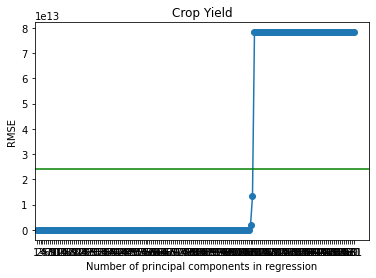

In [39]:
df_new5 = df[df['ECODISTRICT_ID'] == 808]

df_new5.drop(['TWP_ID','ECODISTRICT_ID','YEAR'], axis=1, inplace= True)

Y = df_new5['YieldKgAcre']
df_new5.drop('YieldKgAcre', axis=1, inplace= True)
X = df_new5
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

# Run standardization on X variables
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

# Linear Regression
lin_reg = LinearRegression().fit(X_train_scaled, y_train)
lr_score_train = -1 * cross_val_score(lin_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lr_score_test = mean_squared_error(y_test, lin_reg.predict(X_test_scaled), squared=False)

X_train_pc = pca.fit_transform(X_train_scaled)

# View first 5 rows of all principal components
pd.DataFrame(pca.components_.T).loc[:4,:]

print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

# Initialize linear regression instance
lin_reg = LinearRegression()

# Create empty list to store RMSE for each iteration
rmse_list = []

# Loop through different count of principal components for linear regression
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg, 
                                      X_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=cv, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)
    
# Visual analysis - plot RMSE vs count of principal components used
plt.plot(rmse_list, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('RMSE')
plt.title('Crop Yield')
plt.xlim(xmin=-1);
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle='-');

# determine optimal number of principal components
best_pc_num = 21

# Train model with first 9 principal components
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get cross-validation RMSE (train set)
pcr_score_train = -1 * cross_val_score(lin_reg_pc, 
                                       X_train_pc[:,:best_pc_num], 
                                       y_train, 
                                       cv=cv, 
                                       scoring='neg_root_mean_squared_error').mean()

# Train model on training set
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get first 21 principal components of test set
X_test_pc = pca.transform(X_test_scaled)[:,:best_pc_num]

# Predict on test data
preds = lin_reg_pc.predict(X_test_pc)
pcr_score_test = mean_squared_error(y_test, preds, squared=False)

print('MSE training set',round(pcr_score_train,2))
print('MSE test set',round(pcr_score_test,2))
print('R squared training set', round(lin_reg_pc.score(X_train_pc[:,:best_pc_num], y_train)*100, 2))
print('R squared test set', round(lin_reg_pc.score(X_test_pc[:,:best_pc_num], y_test)*100, 2))

# Calculate the absolute errors
errors = abs(preds - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

C:\Users\Navdeep Singh Saini\miniconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


[27.41 43.38 54.38 62.22 67.41 71.78 75.91 79.58 82.81 85.09 87.12 88.81
 90.35 91.79 92.7  93.57 94.36 94.96 95.54 95.99 96.38 96.76 97.1  97.4
 97.69 97.94 98.12 98.29 98.44 98.58 98.71 98.82 98.92 99.01 99.1  99.18
 99.25 99.32 99.38 99.44 99.49 99.54 99.58 99.62 99.66 99.69 99.72 99.75
 99.78 99.8  99.82 99.84 99.86 99.88 99.89 99.9  99.91 99.92 99.93 99.94
 99.95 99.96 99.97 99.98 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99]
MSE training set 112

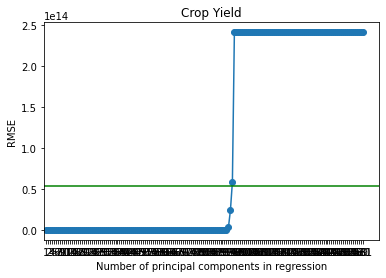

In [38]:
df_new6 = df[df['ECODISTRICT_ID'] == 792]

df_new6.drop(['TWP_ID','ECODISTRICT_ID','YEAR'], axis=1, inplace= True)

Y = df_new6['YieldKgAcre']
df_new6.drop('YieldKgAcre', axis=1, inplace= True)
X = df_new6
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

# Run standardization on X variables
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

# Linear Regression
lin_reg = LinearRegression().fit(X_train_scaled, y_train)
lr_score_train = -1 * cross_val_score(lin_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lr_score_test = mean_squared_error(y_test, lin_reg.predict(X_test_scaled), squared=False)

X_train_pc = pca.fit_transform(X_train_scaled)

# View first 5 rows of all principal components
pd.DataFrame(pca.components_.T).loc[:4,:]

print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

# Initialize linear regression instance
lin_reg = LinearRegression()

# Create empty list to store RMSE for each iteration
rmse_list = []

# Loop through different count of principal components for linear regression
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg, 
                                      X_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=cv, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)
    
# Visual analysis - plot RMSE vs count of principal components used
plt.plot(rmse_list, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('RMSE')
plt.title('Crop Yield')
plt.xlim(xmin=-1);
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle='-');

# determine optimal number of principal components
best_pc_num = 19

# Train model with first 9 principal components
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get cross-validation RMSE (train set)
pcr_score_train = -1 * cross_val_score(lin_reg_pc, 
                                       X_train_pc[:,:best_pc_num], 
                                       y_train, 
                                       cv=cv, 
                                       scoring='neg_root_mean_squared_error').mean()

# Train model on training set
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get first 19 principal components of test set
X_test_pc = pca.transform(X_test_scaled)[:,:best_pc_num]

# Predict on test data
preds = lin_reg_pc.predict(X_test_pc)
pcr_score_test = mean_squared_error(y_test, preds, squared=False)

print('MSE training set',round(pcr_score_train,2))
print('MSE test set',round(pcr_score_test,2))
print('R squared training set', round(lin_reg_pc.score(X_train_pc[:,:best_pc_num], y_train)*100, 2))
print('R squared test set', round(lin_reg_pc.score(X_test_pc[:,:best_pc_num], y_test)*100, 2))

# Calculate the absolute errors
errors = abs(preds - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

C:\Users\Navdeep Singh Saini\miniconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


[21.65 36.44 48.63 56.18 63.04 68.62 72.72 76.33 78.91 81.32 83.29 84.92
 86.3  87.55 88.66 89.72 90.65 91.4  92.1  92.73 93.26 93.78 94.24 94.69
 95.13 95.5  95.85 96.16 96.44 96.7  96.93 97.14 97.33 97.5  97.66 97.81
 97.95 98.07 98.19 98.3  98.4  98.5  98.59 98.67 98.75 98.82 98.89 98.96
 99.03 99.09 99.15 99.2  99.25 99.29 99.33 99.37 99.41 99.45 99.48 99.51
 99.54 99.57 99.6  99.62 99.64 99.66 99.68 99.7  99.72 99.74 99.75 99.76
 99.77 99.78 99.79 99.8  99.81 99.82 99.83 99.84 99.85 99.86 99.87 99.88
 99.89 99.9  99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91
 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91
 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91
 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91
 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91
 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91 99.91
 99.91 99.91 99.91 99.91 99.91]
MSE training set 10

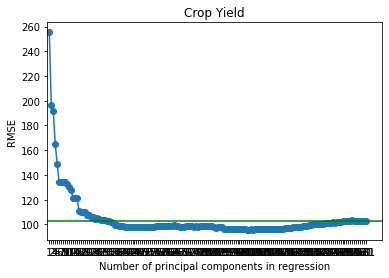

In [37]:
df_new7 = df[df['ECODISTRICT_ID'] == 849]

df_new7.drop(['TWP_ID','ECODISTRICT_ID','YEAR'], axis=1, inplace= True)

Y = df_new7['YieldKgAcre']
df_new7.drop('YieldKgAcre', axis=1, inplace= True)
X = df_new7
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

# Run standardization on X variables
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

# Linear Regression
lin_reg = LinearRegression().fit(X_train_scaled, y_train)
lr_score_train = -1 * cross_val_score(lin_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lr_score_test = mean_squared_error(y_test, lin_reg.predict(X_test_scaled), squared=False)

X_train_pc = pca.fit_transform(X_train_scaled)

# View first 5 rows of all principal components
pd.DataFrame(pca.components_.T).loc[:4,:]

print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

# Initialize linear regression instance
lin_reg = LinearRegression()

# Create empty list to store RMSE for each iteration
rmse_list = []

# Loop through different count of principal components for linear regression
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg, 
                                      X_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=cv, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)
    
# Visual analysis - plot RMSE vs count of principal components used
plt.plot(rmse_list, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('RMSE')
plt.title('Crop Yield')
plt.xlim(xmin=-1);
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle='-');

# determine optimal number of principal components
best_pc_num = 25

# Train model with first 9 principal components
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get cross-validation RMSE (train set)
pcr_score_train = -1 * cross_val_score(lin_reg_pc, 
                                       X_train_pc[:,:best_pc_num], 
                                       y_train, 
                                       cv=cv, 
                                       scoring='neg_root_mean_squared_error').mean()

# Train model on training set
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get first 25 principal components of test set
X_test_pc = pca.transform(X_test_scaled)[:,:best_pc_num]

# Predict on test data
preds = lin_reg_pc.predict(X_test_pc)
pcr_score_test = mean_squared_error(y_test, preds, squared=False)

print('MSE training set',round(pcr_score_train,2))
print('MSE test set',round(pcr_score_test,2))
print('R squared training set', round(lin_reg_pc.score(X_train_pc[:,:best_pc_num], y_train)*100, 2))
print('R squared test set', round(lin_reg_pc.score(X_test_pc[:,:best_pc_num], y_test)*100, 2))

# Calculate the absolute errors
errors = abs(preds - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

C:\Users\Navdeep Singh Saini\miniconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


[18.33 33.31 44.89 52.94 59.91 64.81 69.   72.74 75.94 78.87 81.17 83.16
 84.85 86.49 87.9  89.2  90.25 91.27 92.13 92.92 93.64 94.22 94.76 95.25
 95.69 96.11 96.5  96.86 97.16 97.41 97.64 97.84 98.02 98.18 98.32 98.46
 98.58 98.7  98.81 98.91 99.01 99.11 99.19 99.27 99.34 99.41 99.47 99.52
 99.57 99.61 99.65 99.69 99.72 99.75 99.77 99.79 99.81 99.83 99.85 99.86
 99.87 99.88 99.89 99.9  99.91 99.92 99.93 99.94 99.95 99.96 99.97 99.98
 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98
 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98
 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98
 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98
 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98
 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98
 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98
 99.98 99.98 99.98 99.98 99.98]
MSE training set 10

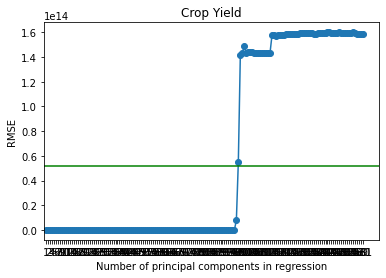

In [33]:
df_new8 = df[df['ECODISTRICT_ID'] == 729]

df_new8.drop(['TWP_ID','ECODISTRICT_ID','YEAR'], axis=1, inplace= True)

Y = df_new8['YieldKgAcre']
df_new8.drop('YieldKgAcre', axis=1, inplace= True)
X = df_new8
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

# Run standardization on X variables
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

# Linear Regression
lin_reg = LinearRegression().fit(X_train_scaled, y_train)
lr_score_train = -1 * cross_val_score(lin_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lr_score_test = mean_squared_error(y_test, lin_reg.predict(X_test_scaled), squared=False)

X_train_pc = pca.fit_transform(X_train_scaled)

# View first 5 rows of all principal components
pd.DataFrame(pca.components_.T).loc[:4,:]

print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

# Initialize linear regression instance
lin_reg = LinearRegression()

# Create empty list to store RMSE for each iteration
rmse_list = []

# Loop through different count of principal components for linear regression
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg, 
                                      X_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=cv, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)
    
# Visual analysis - plot RMSE vs count of principal components used
plt.plot(rmse_list, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('RMSE')
plt.title('Crop Yield')
plt.xlim(xmin=-1);
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle='-');

# determine optimal number of principal components
best_pc_num = 23

# Train model with first 9 principal components
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get cross-validation RMSE (train set)
pcr_score_train = -1 * cross_val_score(lin_reg_pc, 
                                       X_train_pc[:,:best_pc_num], 
                                       y_train, 
                                       cv=cv, 
                                       scoring='neg_root_mean_squared_error').mean()

# Train model on training set
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get first 23 principal components of test set
X_test_pc = pca.transform(X_test_scaled)[:,:best_pc_num]

# Predict on test data
preds = lin_reg_pc.predict(X_test_pc)
pcr_score_test = mean_squared_error(y_test, preds, squared=False)

print('MSE training set',round(pcr_score_train,2))
print('MSE test set',round(pcr_score_test,2))
print('R squared training set', round(lin_reg_pc.score(X_train_pc[:,:best_pc_num], y_train)*100, 2))
print('R squared test set', round(lin_reg_pc.score(X_test_pc[:,:best_pc_num], y_test)*100, 2))

# Calculate the absolute errors
errors = abs(preds - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

C:\Users\Navdeep Singh Saini\miniconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


[20.42 35.59 46.64 55.83 63.29 68.25 73.04 76.4  79.38 82.13 84.35 86.06
 87.51 88.82 89.92 90.92 91.85 92.55 93.2  93.75 94.29 94.77 95.2  95.57
 95.9  96.21 96.48 96.72 96.94 97.14 97.33 97.5  97.66 97.82 97.97 98.11
 98.23 98.35 98.45 98.55 98.64 98.73 98.81 98.89 98.96 99.03 99.09 99.15
 99.21 99.26 99.31 99.35 99.39 99.43 99.47 99.51 99.54 99.57 99.6  99.63
 99.65 99.67 99.69 99.71 99.73 99.75 99.77 99.79 99.8  99.81 99.82 99.83
 99.84 99.85 99.86 99.87 99.88 99.89 99.9  99.91 99.92 99.93 99.93 99.93
 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93
 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93
 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93
 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93
 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93
 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93 99.93
 99.93 99.93 99.93 99.93 99.93]
MSE training set 74

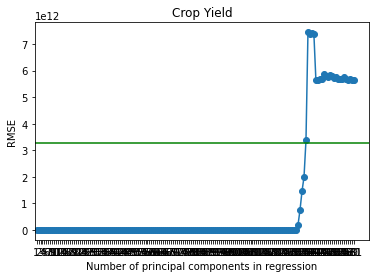

In [36]:
df_new9 = df[df['ECODISTRICT_ID'] == 753]

df_new9.drop(['TWP_ID','ECODISTRICT_ID','YEAR'], axis=1, inplace= True)

Y = df_new9['YieldKgAcre']
df_new9.drop('YieldKgAcre', axis=1, inplace= True)
X = df_new9
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

# Run standardization on X variables
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

# Linear Regression
lin_reg = LinearRegression().fit(X_train_scaled, y_train)
lr_score_train = -1 * cross_val_score(lin_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lr_score_test = mean_squared_error(y_test, lin_reg.predict(X_test_scaled), squared=False)

X_train_pc = pca.fit_transform(X_train_scaled)

# View first 5 rows of all principal components
pd.DataFrame(pca.components_.T).loc[:4,:]

print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

# Initialize linear regression instance
lin_reg = LinearRegression()

# Create empty list to store RMSE for each iteration
rmse_list = []

# Loop through different count of principal components for linear regression
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg, 
                                      X_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=cv, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)
    
# Visual analysis - plot RMSE vs count of principal components used
plt.plot(rmse_list, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('RMSE')
plt.title('Crop Yield')
plt.xlim(xmin=-1);
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle='-');

# determine optimal number of principal components
best_pc_num = 23

# Train model with first 9 principal components
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get cross-validation RMSE (train set)
pcr_score_train = -1 * cross_val_score(lin_reg_pc, 
                                       X_train_pc[:,:best_pc_num], 
                                       y_train, 
                                       cv=cv, 
                                       scoring='neg_root_mean_squared_error').mean()

# Train model on training set
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get first 23 principal components of test set
X_test_pc = pca.transform(X_test_scaled)[:,:best_pc_num]

# Predict on test data
preds = lin_reg_pc.predict(X_test_pc)
pcr_score_test = mean_squared_error(y_test, preds, squared=False)

print('MSE training set',round(pcr_score_train,2))
print('MSE test set',round(pcr_score_test,2))
print('R squared training set', round(lin_reg_pc.score(X_train_pc[:,:best_pc_num], y_train)*100, 2))
print('R squared test set', round(lin_reg_pc.score(X_test_pc[:,:best_pc_num], y_test)*100, 2))

# Calculate the absolute errors
errors = abs(preds - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

C:\Users\Navdeep Singh Saini\miniconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


[20.33 34.39 44.84 52.16 58.42 64.13 68.74 72.56 76.09 78.82 81.42 83.62
 85.52 87.13 88.53 89.61 90.52 91.41 92.17 92.85 93.43 93.97 94.46 94.91
 95.32 95.69 96.02 96.33 96.62 96.9  97.11 97.31 97.49 97.66 97.81 97.96
 98.11 98.25 98.37 98.48 98.58 98.68 98.77 98.85 98.93 99.01 99.08 99.15
 99.21 99.27 99.32 99.37 99.42 99.46 99.5  99.53 99.56 99.59 99.62 99.65
 99.68 99.71 99.73 99.75 99.77 99.79 99.81 99.82 99.83 99.84 99.85 99.86
 99.87 99.88 99.89 99.9  99.91 99.92 99.93 99.94 99.95 99.96 99.96 99.96
 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96
 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96
 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96
 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96
 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96
 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96 99.96
 99.96 99.96 99.96 99.96 99.96]
MSE training set 10

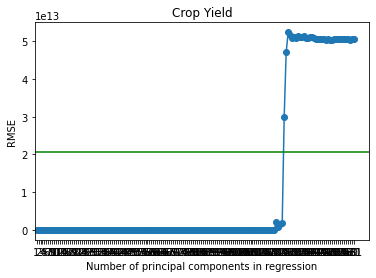

In [35]:
df_new10 = df[df['ECODISTRICT_ID'] == 709]

df_new10.drop(['TWP_ID','ECODISTRICT_ID','YEAR'], axis=1, inplace= True)

Y = df_new10['YieldKgAcre']
df_new10.drop('YieldKgAcre', axis=1, inplace= True)
X = df_new10
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

# Run standardization on X variables
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

# Linear Regression
lin_reg = LinearRegression().fit(X_train_scaled, y_train)
lr_score_train = -1 * cross_val_score(lin_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lr_score_test = mean_squared_error(y_test, lin_reg.predict(X_test_scaled), squared=False)

X_train_pc = pca.fit_transform(X_train_scaled)

# View first 5 rows of all principal components
pd.DataFrame(pca.components_.T).loc[:4,:]

print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

# Initialize linear regression instance
lin_reg = LinearRegression()

# Create empty list to store RMSE for each iteration
rmse_list = []

# Loop through different count of principal components for linear regression
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg, 
                                      X_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=cv, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)
    
# Visual analysis - plot RMSE vs count of principal components used
plt.plot(rmse_list, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('RMSE')
plt.title('Crop Yield')
plt.xlim(xmin=-1);
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle='-');

# determine optimal number of principal components
best_pc_num = 25

# Train model with first 9 principal components
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get cross-validation RMSE (train set)
pcr_score_train = -1 * cross_val_score(lin_reg_pc, 
                                       X_train_pc[:,:best_pc_num], 
                                       y_train, 
                                       cv=cv, 
                                       scoring='neg_root_mean_squared_error').mean()

# Train model on training set
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get first 25 principal components of test set
X_test_pc = pca.transform(X_test_scaled)[:,:best_pc_num]

# Predict on test data
preds = lin_reg_pc.predict(X_test_pc)
pcr_score_test = mean_squared_error(y_test, preds, squared=False)

print('MSE training set',round(pcr_score_train,2))
print('MSE test set',round(pcr_score_test,2))
print('R squared training set', round(lin_reg_pc.score(X_train_pc[:,:best_pc_num], y_train)*100, 2))
print('R squared test set', round(lin_reg_pc.score(X_test_pc[:,:best_pc_num], y_test)*100, 2))

# Calculate the absolute errors
errors = abs(preds - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')